In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pyodbc

#### Get Space actuals and pre-process the data: (1) aggregate daily to monthly grain by sumproduct (2) split to all-up actuals and organic actuals

In [ ]:
server = 'monetizationdashboards.database.windows.net'
database = 'monetizationdashboards'
username = 'adsreadonly'
password = '$Bnc>ps3NeZc-cWE'
driver= '{ODBC Driver 13 for SQL Server}'
cnxn = pyodbc.connect('DRIVER='+driver+';PORT=1433;SERVER='+server+';PORT=1443;DATABASE='+database+';UID='+username+';PWD='+ password)

In [ ]:
sql_actuals = """
DECLARE @StartDate Date
SET @StartDate = '2017-07-01'

DECLARE @EndDate Date
SET @EndDate = '2018-06-30'

SELECT  [Date]
        ,[Market]
        ,[Segment]
        ,[Impressions_SLAPI]
        ,[Space_PxMLIY_Logged_Text]
        ,[Space_PxMLIY_Logged_Decoration]
        ,([Space_PxMLIY_Logged_Text]+[Space_PxMLIY_Logged_Decoration])*[Impressions_SLAPI] AS WeightedTAImpressions
FROM
(
    SELECT [Date], [Market], [Segment], [Metric], [Value]
    FROM [PxMLIY].[vData]
    WHERE 
    (
        Market like'%en-CA-NonDap%'
        OR Market like'%fr-FR-NonDap%' 
        OR Market like'%de-DE-NonDap%' 
        OR Market like'%en-AU-NonDap%'
        OR Market like'%en-GB-NonDap%'
    )
    AND Segment IN ('Bing O&O Core Browse PC+Tablet-ALL', 'Bing O&O Core Browse PC+Tablet-Organic')
    AND [Date] between @StartDate and @EndDate
) AS SourceView

PIVOT
(
    SUM([Value])
    FOR [Metric] IN ([Space_PxMLIY_Logged_Text], [Space_PxMLIY_Logged_Decoration], [Impressions_SLAPI], [Space_PxMLIY_Logged], [Space_PxMLIY_Logged_PA])
) AS PivotTable

"""

In [ ]:
%time df = pd.read_sql(sql_actuals, cnxn)

In [ ]:
df = pd.read_csv('RawData/AdSpaceActual_20180409.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df['CalendarPeriod'] = df['Date'].dt.to_period('M')

In [4]:
df.set_index('Date', inplace = True)

In [5]:
condlist = [df['Market'].str.contains('en-GB'), df['Market'].str.contains('de-DE'), df['Market'].str.contains('fr-FR'), df['Market'].str.contains('en-AU'), df['Market'].str.contains('en-CA')]
choicelist = [1, 2, 3, 4, 5]

df['Market_Tag'] = np.select(condlist, choicelist)

df['WeightedTextImpressions'] = df['Impressions_SLAPI'] * df['Space_PxMLIY_Logged_Decoration']
df['WeightedDecoImpressions'] = df['Impressions_SLAPI'] * df['Space_PxMLIY_Logged_Text']

In [6]:
# Get monthly grain, sumproduct daily PxMLIY and SRPV to get monthly PxMLIY data
df_nonDap_monthly = df.groupby([pd.Grouper(freq='MS'), 'Segment', 'Market', 'Market_Tag', 'CalendarPeriod'])[['Impressions_SLAPI', 'WeightedTAImpressions', 'WeightedTextImpressions', 'WeightedDecoImpressions']].sum().reset_index()
df_nonDap_monthly['PxMLIY_TA'] = df_nonDap_monthly['WeightedTAImpressions'] / df_nonDap_monthly['Impressions_SLAPI']
df_nonDap_monthly['PxMLIY_Text'] = df_nonDap_monthly['WeightedTextImpressions'] / df_nonDap_monthly['Impressions_SLAPI']
df_nonDap_monthly['PxMLIY_Deco'] = df_nonDap_monthly['WeightedDecoImpressions'] / df_nonDap_monthly['Impressions_SLAPI']
df_nonDap_monthly['DecoRatio'] = df_nonDap_monthly['PxMLIY_Deco'] / df_nonDap_monthly['PxMLIY_TA']

In [7]:
# Split the whole nonDap data to all-up and organic
df_nonDap_all_monthly = df_nonDap_monthly[df_nonDap_monthly['Segment'] == 'Bing O&O Core Browse PC+Tablet-ALL']
df_nonDap_org_monthly = df_nonDap_monthly[df_nonDap_monthly['Segment'] == 'Bing O&O Core Browse PC+Tablet-Organic']

In [54]:
# Validate PxMLIY_TA actuals against Victor's email screenshots
df_nonDap_all_monthly[df_nonDap_all_monthly['Date'] == '2018-03-01'].sort_values('Market_Tag', ascending = True)

,Date,Segment,Market,Market_Tag,CalendarPeriod,Impressions_SLAPI,WeightedTAImpressions,WeightedTextImpressions,WeightedDecoImpressions,PxMLIY_TA,PxMLIY_Text,PxMLIY_Deco,DecoRatio
443,2018-03-01,Bing O&O Core Browse PC+Tablet-ALL,en-GB-NonDap-ALL,1,2018-03,655084866,6.195899e+08,2.392552e+08,3.803347e+08,0.945816,0.365228,0.580588,0.613849
440,2018-03-01,Bing O&O Core Browse PC+Tablet-ALL,de-DE-NonDap-ALL,2,2018-03,419573675,4.914034e+08,2.055508e+08,2.858526e+08,1.171197,0.489904,0.681293,0.581707
444,2018-03-01,Bing O&O Core Browse PC+Tablet-ALL,fr-FR-NonDap-ALL,3,2018-03,397435079,3.571743e+08,1.297871e+08,2.273872e+08,0.898699,0.326562,0.572137,0.636628
441,2018-03-01,Bing O&O Core Browse PC+Tablet-ALL,en-AU-NonDap-ALL,4,2018-03,143812315,1.443985e+08,5.600409e+07,8.839444e+07,1.004076,0.389425,0.614651,0.612156
442,2018-03-01,Bing O&O Core Browse PC+Tablet-ALL,en-CA-NonDap-ALL,5,2018-03,240553077,2.280056e+08,8.934338e+07,1.386623e+08,0.947839,0.371408,0.576431,0.608153


<img src="Victor_201803.png">

In [9]:
df_nonDap_all_monthly.head()

,Date,Segment,Market,Market_Tag,CalendarPeriod,Impressions_SLAPI,WeightedTAImpressions,WeightedTextImpressions,WeightedDecoImpressions,PxMLIY_TA,PxMLIY_Text,PxMLIY_Deco,DecoRatio
0,2014-07-01,Bing O&O Core Browse PC+Tablet-ALL,de-DE-NonDap-ALL,2,2014-07,175930323,1.937061e+08,2.396481e+07,1.697412e+08,1.101038,0.136218,0.964821,0.876283
1,2014-07-01,Bing O&O Core Browse PC+Tablet-ALL,en-AU-NonDap-ALL,4,2014-07,107141725,1.405306e+08,1.754632e+07,1.229842e+08,1.311632,0.163767,1.147865,0.875142
2,2014-07-01,Bing O&O Core Browse PC+Tablet-ALL,en-CA-NonDap-ALL,5,2014-07,187341629,1.608365e+08,2.066296e+07,1.401736e+08,0.858520,0.110296,0.748224,0.871528
3,2014-07-01,Bing O&O Core Browse PC+Tablet-ALL,en-GB-NonDap-ALL,1,2014-07,375369276,3.343544e+08,5.773627e+07,2.766182e+08,0.890735,0.153812,0.736923,0.827320
4,2014-07-01,Bing O&O Core Browse PC+Tablet-ALL,fr-FR-NonDap-ALL,3,2014-07,237843612,2.411689e+08,3.062752e+07,2.105414e+08,1.013981,0.128772,0.885209,0.873004


##### Get Space budget data

In [10]:
sql_budget = """

SELECT [Date]
      ,[Market]
      ,[Segment]
      ,[Metric]
      ,[Type]
      ,[Value]
      ,[GuardValue]
  FROM [PxMLIY].[SpaceBudgetData]
  WHERE
       Metric like '%Space_PxMLIY_Logged%'
       AND Segment like '%Core Browse PC+Tablet-ALL%'
       AND Market like '%NonDap-ALL%'

"""
df2 = pd.read_sql(sql_budget, cnxn)
df2['Date'] = pd.to_datetime(df2['Date'])

In [11]:
df2['CalendarPeriod'] = df2['Date'].dt.to_period('M')
df2['Month'] = df2['Date'].dt.strftime('%b')

def C2F(x):
    return np.where(x.dt.month >= 7, x.dt.year+1, x.dt.year)

df2['FiscalYear'] = C2F(df2['Date'])
df2['FiscalYear'] = 'FY'+ df2['FiscalYear'].map(str)

In [12]:
df2_b4FY18 = df2[(df2['Date'] < '2017-07-01') & (df2['Metric'].isin(['Space_PxMLIY_Logged']))]
df2_FY18 = df2[(df2['Date'] >= '2017-07-01') & (df2['Metric'].isin(['Space_PxMLIY_Logged_Text']))]
df_budget = pd.concat([df2_b4FY18, df2_FY18])

In [13]:
df_budget = df_budget.drop(columns = ['Metric', 'Type', 'GuardValue'])

In [14]:
df_budget.rename(columns = {'Value': 'Budget_PxMLIY_TA'}, inplace = True)

In [15]:
# budget data validated in the separate budget jupyter notebook file

#### Get NonDap MLIY/MLCY/RPM from rnramd (all-up, not organic metrics). nonDap text ads MLIY/MLCY/RPM not available in rnramd, so using nonDap overall MLIY/CY/RPM as proxy

In [16]:
df3 = pd.read_csv('RawData/Top5_FY17_18_RPM_MLIY_MLCY_NonDap.csv', 
                  usecols = ['Date', 'Market', 'NonDap_MLIY', 'NonDap_MLCY', 'NonDap_RPM'], 
                  parse_dates = ['Date'])

In [17]:
condlist3 = [df3['Market']=='UK', df3['Market']=='DE', df3['Market']=='FR', df3['Market']=='AU', df3['Market']=='CA']
choicelist3 = [1, 2, 3, 4, 5]

df3['Market_Tag'] = np.select(condlist3, choicelist3)


In [18]:
df3['FiscalYear'] = C2F(df3['Date'])
df3['FiscalYear'] = 'FY' + df3['FiscalYear'].map(str)

In [19]:
# Fx adjust RPM for YoY comparison
df_fx = pd.read_csv('RawData/FXRate.csv', usecols = ['Market', 'FY18', 'FY17'])

In [20]:
df3.head(3)
df_fx['Adjustment'] = df_fx['FY18'] / df_fx['FY17']

In [21]:
df3 = pd.merge(df3, df_fx, how = 'left', left_on = 'Market', right_on = 'Market').drop(columns = ['FY18', 'FY17'])

In [22]:
df3.head()

,Date,Market,NonDap_MLIY,NonDap_MLCY,NonDap_RPM,Market_Tag,FiscalYear,Adjustment
0,2016-07-01,AU,0.711,0.0616,39.58,4,FY2017,1.027397
1,2016-08-01,AU,0.673,0.0584,36.67,4,FY2017,1.027397
2,2016-09-01,AU,0.706,0.0599,38.51,4,FY2017,1.027397
3,2016-10-01,AU,0.729,0.0630,38.93,4,FY2017,1.027397
4,2016-11-01,AU,0.778,0.0679,43.45,4,FY2017,1.027397


In [23]:
df3['NonDap_RPM_FXAdjusted'] = np.where(df3['FiscalYear'] == 'FY2017', df3['NonDap_RPM']*df3['Adjustment'], df3['NonDap_RPM']) 

In [24]:
df3.head()

,Date,Market,NonDap_MLIY,NonDap_MLCY,NonDap_RPM,Market_Tag,FiscalYear,Adjustment,NonDap_RPM_FXAdjusted
0,2016-07-01,AU,0.711,0.0616,39.58,4,FY2017,1.027397,40.664384
1,2016-08-01,AU,0.673,0.0584,36.67,4,FY2017,1.027397,37.674658
2,2016-09-01,AU,0.706,0.0599,38.51,4,FY2017,1.027397,39.565068
3,2016-10-01,AU,0.729,0.0630,38.93,4,FY2017,1.027397,39.996575
4,2016-11-01,AU,0.778,0.0679,43.45,4,FY2017,1.027397,44.640411


In [25]:
df3 = df3[['Date', 'Market', 'Market_Tag', 'NonDap_MLIY', 'NonDap_MLCY', 'NonDap_RPM', 'NonDap_RPM_FXAdjusted']]

#### Merge three data frames: nonDap text actuals all-up (df_nonDap_all_monthly), nonDap text budget all-up (df_budget), and nonDap MLIY/MLCY/RPM all-up (df3). Leave nonDap text actuals organic data frame separate.

In [26]:
# keys for df_nonDap_all_monthly and df_budget: Date, market
# keys for df_nonDap_all_monthly and df3: Date, Market_Tag

In [27]:
df_nonDap_all_monthly.head(3)

,Date,Segment,Market,Market_Tag,CalendarPeriod,Impressions_SLAPI,WeightedTAImpressions,WeightedTextImpressions,WeightedDecoImpressions,PxMLIY_TA,PxMLIY_Text,PxMLIY_Deco,DecoRatio
0,2014-07-01,Bing O&O Core Browse PC+Tablet-ALL,de-DE-NonDap-ALL,2,2014-07,175930323,1.937061e+08,2.396481e+07,1.697412e+08,1.101038,0.136218,0.964821,0.876283
1,2014-07-01,Bing O&O Core Browse PC+Tablet-ALL,en-AU-NonDap-ALL,4,2014-07,107141725,1.405306e+08,1.754632e+07,1.229842e+08,1.311632,0.163767,1.147865,0.875142
2,2014-07-01,Bing O&O Core Browse PC+Tablet-ALL,en-CA-NonDap-ALL,5,2014-07,187341629,1.608365e+08,2.066296e+07,1.401736e+08,0.858520,0.110296,0.748224,0.871528


In [28]:
df4 = pd.merge(df_nonDap_all_monthly, df_budget, how = 'inner', left_on = ['Date', 'Market'], right_on = ['Date', 'Market'])

In [29]:
df4 = df4[['Date', 'Market', 'Market_Tag', 'CalendarPeriod_x', 'PxMLIY_TA', 'PxMLIY_Text', 
           'PxMLIY_Deco', 'DecoRatio', 'Budget_PxMLIY_TA', 'Month', 'FiscalYear']]

In [30]:
df4.rename(columns = {'CalendarPeriod_x': 'CalendarPeriod', 'PxMLIY_TA': 'Actuals_PxMLIY_TA',
                     'PxMLIY_Text':'Actuals_PxMLIY_Text', 'PxMLIY_Deco': 'Actuals_PxMLIY_Deco',
                      'DecoRatio':'Actuals_DecoRatio'}, inplace = True)

In [31]:
df_final = pd.merge(df4, df3, how = 'inner', left_on = ['Date', 'Market_Tag'], right_on = ['Date', 'Market_Tag'])

#### Analysis

In [32]:
# df_final for FY17-18 nonDap text space budget and actuals, nonDap RPM/MLIY/MLCY, deco ratio analysis
# df_nonDap_org_monthly for FY15-18 organic segment actuals analysis --> need to get organic nonDap MLIY/MLCY/RPM
# df4 (join of df_nonDap_all_monthly and df_budget) for FY15-18 nonDap text space actuls vs budget analysis

In [33]:
df_final.to_csv('OutputFiles/Final.csv', index = False)
# Actual PxMLIY vs budget PxMLIY vs RPM done in Final_FxAdjusted.xlsx in OutputFiles

In [34]:
df_final.head()

,Date,Market_x,Market_Tag,CalendarPeriod,Actuals_PxMLIY_TA,Actuals_PxMLIY_Text,Actuals_PxMLIY_Deco,Actuals_DecoRatio,Budget_PxMLIY_TA,Month,FiscalYear,Market_y,NonDap_MLIY,NonDap_MLCY,NonDap_RPM,NonDap_RPM_FXAdjusted
0,2016-07-01,de-DE-NonDap-ALL,2,2016-07,0.923471,0.184957,0.738514,0.799715,1.022,Jul,FY2017,DE,0.737,0.0626,28.02,27.772035
1,2016-07-01,en-AU-NonDap-ALL,4,2016-07,1.107341,0.386584,0.720757,0.650890,1.122,Jul,FY2017,AU,0.711,0.0616,39.58,40.664384
2,2016-07-01,en-CA-NonDap-ALL,5,2016-07,0.851735,0.257890,0.593845,0.697218,0.864,Jul,FY2017,CA,0.587,0.0466,27.50,27.293091
3,2016-07-01,en-GB-NonDap-ALL,1,2016-07,0.801150,0.277212,0.523939,0.653983,0.840,Jul,FY2017,UK,0.497,0.0562,47.29,41.177687
4,2016-07-01,fr-FR-NonDap-ALL,3,2016-07,0.978993,0.259706,0.719286,0.734721,0.980,Jul,FY2017,FR,0.719,0.0629,22.65,22.449558


In [35]:
# Plot RPM vs PxMLIY scatterplot
sns.set_style('darkgrid')
sns.set_context('talk')

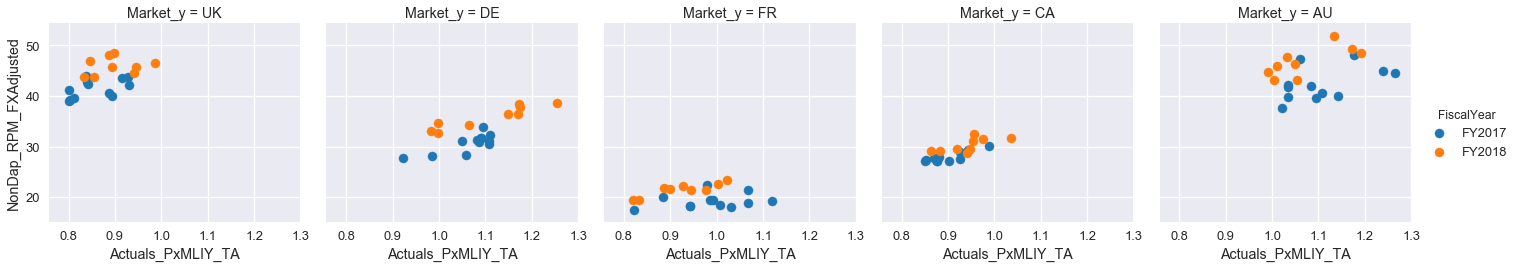

In [36]:
g = sns.FacetGrid(df_final, col = 'Market_y', hue = 'FiscalYear', col_order = ['UK', 'DE', 'FR', 'CA', 'AU'], size = 4)
g.map(plt.scatter, 'Actuals_PxMLIY_TA', 'NonDap_RPM_FXAdjusted').add_legend()
#g.ax.set(title = 'Actual Non-Dap PxMLIY TA vs. Non-Dap RPM')
#g.fig.autofmt_xdate()

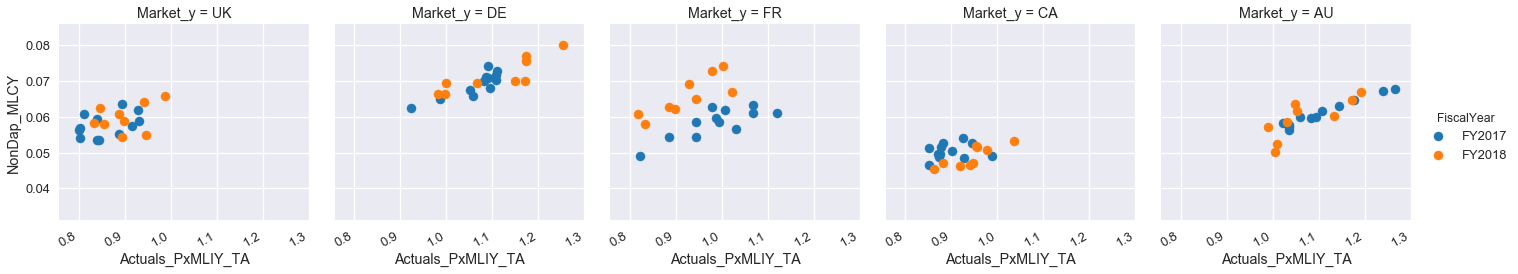

In [37]:
g = sns.FacetGrid(df_final, col = 'Market_y', hue = 'FiscalYear', col_order = ['UK', 'DE', 'FR', 'CA', 'AU'], size = 4)
g.map(plt.scatter, 'Actuals_PxMLIY_TA', 'NonDap_MLCY').add_legend()
g.fig.autofmt_xdate()

In [38]:
# Need to compute linear regression for each market

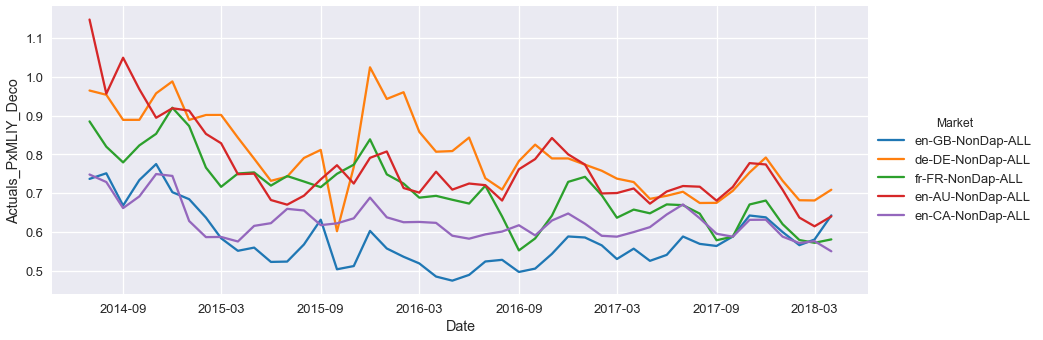

In [39]:
# Plot richness
g = sns.FacetGrid(df4[df4['Date']>= '2014-07-01'], hue = 'Market', size = 5, aspect = 2.5, 
                  hue_order = ['en-GB-NonDap-ALL', 'de-DE-NonDap-ALL', 'fr-FR-NonDap-ALL', 'en-AU-NonDap-ALL', 'en-CA-NonDap-ALL'])
g.map(plt.plot, 'Date', 'Actuals_PxMLIY_Deco').add_legend()

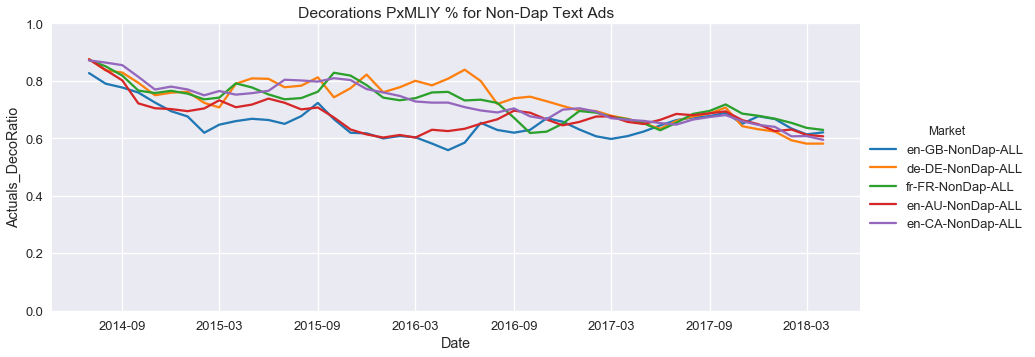

In [40]:
g = sns.FacetGrid(df4[df4['Date']>= '2014-07-01'], hue = 'Market', size = 5, aspect = 2.5, 
                  hue_order = ['en-GB-NonDap-ALL', 'de-DE-NonDap-ALL', 'fr-FR-NonDap-ALL', 'en-AU-NonDap-ALL', 'en-CA-NonDap-ALL'])
g.map(plt.plot, 'Date', 'Actuals_DecoRatio').add_legend()
g.ax.set(title = 'Decorations PxMLIY % for Non-Dap Text Ads')
g.set(ylim = (0, 1))

In [41]:
condlist4 = [df_nonDap_monthly['Market_Tag']==1, df_nonDap_monthly['Market_Tag']==2, df_nonDap_monthly['Market_Tag']==3, df_nonDap_monthly['Market_Tag']==4, df_nonDap_monthly['Market_Tag']==5]
choicelist4 = ['UK', 'DE', 'FR', 'AU', 'CA']

df_nonDap_monthly['Market_y'] = np.select(condlist4, choicelist4)


df_nonDap_monthly.head()

,Date,Segment,Market,Market_Tag,CalendarPeriod,Impressions_SLAPI,WeightedTAImpressions,WeightedTextImpressions,WeightedDecoImpressions,PxMLIY_TA,PxMLIY_Text,PxMLIY_Deco,DecoRatio,Market_y
0,2014-07-01,Bing O&O Core Browse PC+Tablet-ALL,de-DE-NonDap-ALL,2,2014-07,175930323,1.937061e+08,2.396481e+07,1.697412e+08,1.101038,0.136218,0.964821,0.876283,DE
1,2014-07-01,Bing O&O Core Browse PC+Tablet-ALL,en-AU-NonDap-ALL,4,2014-07,107141725,1.405306e+08,1.754632e+07,1.229842e+08,1.311632,0.163767,1.147865,0.875142,AU
2,2014-07-01,Bing O&O Core Browse PC+Tablet-ALL,en-CA-NonDap-ALL,5,2014-07,187341629,1.608365e+08,2.066296e+07,1.401736e+08,0.858520,0.110296,0.748224,0.871528,CA
3,2014-07-01,Bing O&O Core Browse PC+Tablet-ALL,en-GB-NonDap-ALL,1,2014-07,375369276,3.343544e+08,5.773627e+07,2.766182e+08,0.890735,0.153812,0.736923,0.827320,UK
4,2014-07-01,Bing O&O Core Browse PC+Tablet-ALL,fr-FR-NonDap-ALL,3,2014-07,237843612,2.411689e+08,3.062752e+07,2.105414e+08,1.013981,0.128772,0.885209,0.873004,FR


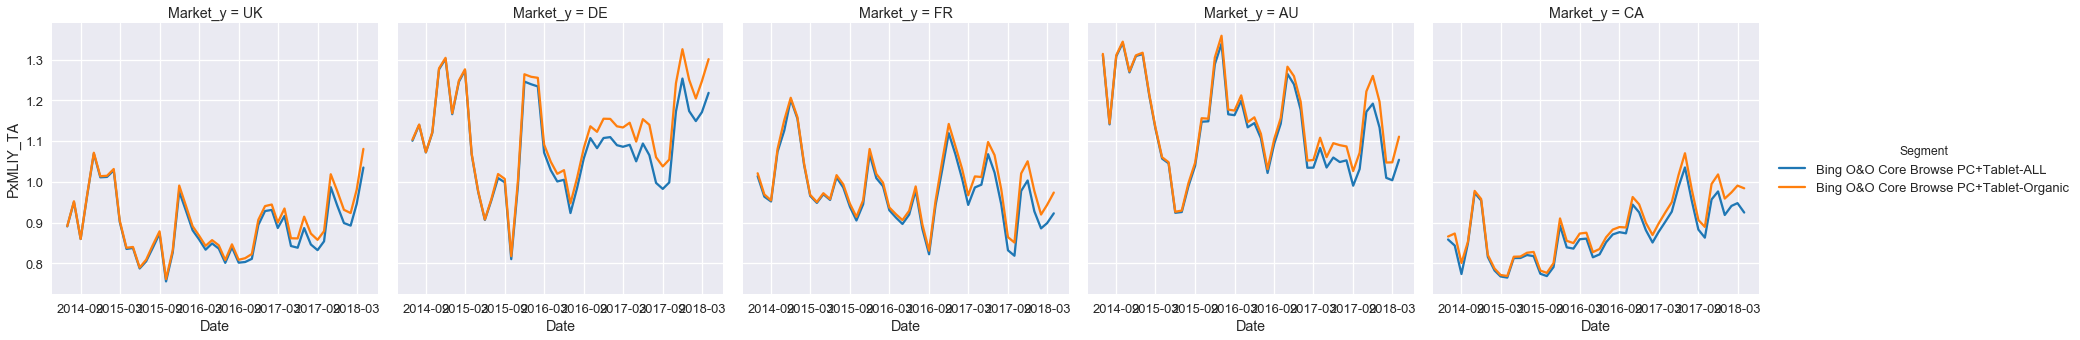

In [42]:
g = sns.FacetGrid(df_nonDap_monthly, col = 'Market_y', hue = 'Segment', size = 5, col_order = ['UK', 'DE', 'FR', 'AU', 'CA'], 
                  hue_order = ['Bing O&O Core Browse PC+Tablet-ALL', 'Bing O&O Core Browse PC+Tablet-Organic'])
g.map(plt.plot, 'Date', 'PxMLIY_TA').add_legend()
#g.ax.set(title = 'Non-Dap PxMLIY_TA for All vs Organic')

In [43]:
df_final['VTB'] = df_final['Actuals_PxMLIY_TA'] / df_final['Budget_PxMLIY_TA'] - 1

In [44]:
df_final.head(3)

,Date,Market_x,Market_Tag,CalendarPeriod,Actuals_PxMLIY_TA,Actuals_PxMLIY_Text,Actuals_PxMLIY_Deco,Actuals_DecoRatio,Budget_PxMLIY_TA,Month,FiscalYear,Market_y,NonDap_MLIY,NonDap_MLCY,NonDap_RPM,NonDap_RPM_FXAdjusted,VTB
0,2016-07-01,de-DE-NonDap-ALL,2,2016-07,0.923471,0.184957,0.738514,0.799715,1.022,Jul,FY2017,DE,0.737,0.0626,28.02,27.772035,-0.096408
1,2016-07-01,en-AU-NonDap-ALL,4,2016-07,1.107341,0.386584,0.720757,0.650890,1.122,Jul,FY2017,AU,0.711,0.0616,39.58,40.664384,-0.013065
2,2016-07-01,en-CA-NonDap-ALL,5,2016-07,0.851735,0.257890,0.593845,0.697218,0.864,Jul,FY2017,CA,0.587,0.0466,27.50,27.293091,-0.014196


Text(0.5,1,'Space VTB by Fiscal Year')

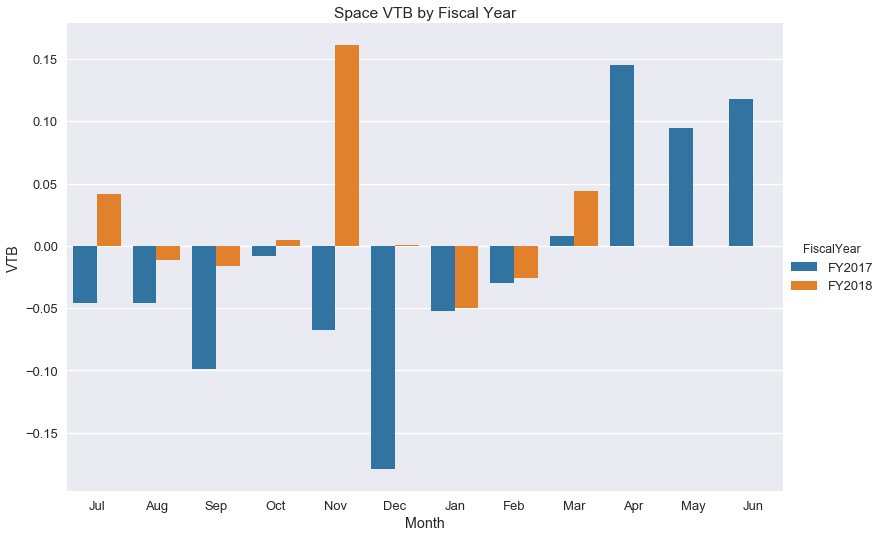

In [45]:
g = sns.factorplot(x='Month', y='VTB', hue='FiscalYear',
                   data=df_final[df_final['Market_y']== 'UK'], kind='bar',
                   order=['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'],
                   size=7.5, aspect=1.5)
g.ax.set_title('Space VTB by Fiscal Year')

[Text(0.5,1,'UK - Non-Dap Text Ads PxMLIY for All vs Organic')]

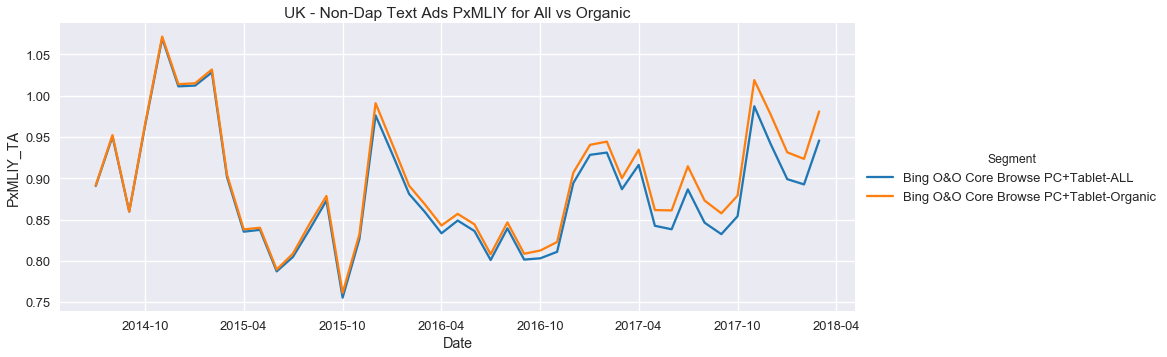

In [46]:
g = sns.FacetGrid(df_nonDap_monthly[(df_nonDap_monthly['Market_y']=='UK') & (df_nonDap_monthly['Date'] < '2018-04-01')], hue = 'Segment', size = 5, aspect = 2.5)
g.map(plt.plot, 'Date', 'PxMLIY_TA').add_legend()
g.ax.set(title = 'UK - Non-Dap Text Ads PxMLIY for All vs Organic')

[Text(0.5,1,'DE - Non-Dap Text Ads PxMLIY for All vs Organic')]

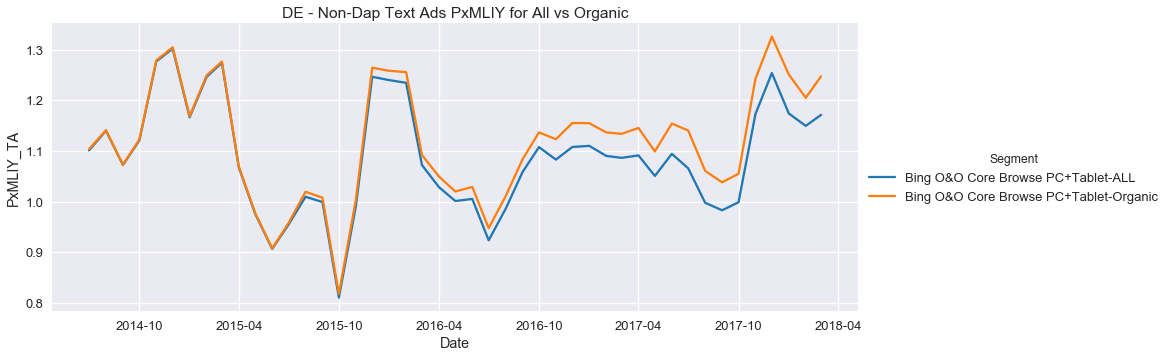

In [47]:
g = sns.FacetGrid(df_nonDap_monthly[(df_nonDap_monthly['Market_y']=='DE') & (df_nonDap_monthly['Date'] < '2018-04-01')], hue = 'Segment', size = 5, aspect = 2.5)
g.map(plt.plot, 'Date', 'PxMLIY_TA').add_legend()
g.ax.set(title = 'DE - Non-Dap Text Ads PxMLIY for All vs Organic')

[Text(0.5,1,'FR - Non-Dap Text Ads PxMLIY for All vs Organic')]

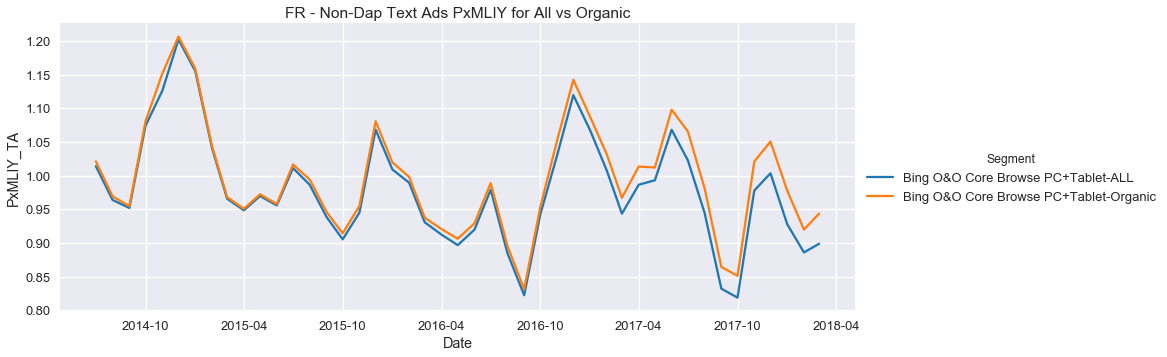

In [48]:
g = sns.FacetGrid(df_nonDap_monthly[(df_nonDap_monthly['Market_y']=='FR') & (df_nonDap_monthly['Date'] < '2018-04-01')], hue = 'Segment', size = 5, aspect = 2.5)
g.map(plt.plot, 'Date', 'PxMLIY_TA').add_legend()
g.ax.set(title = 'FR - Non-Dap Text Ads PxMLIY for All vs Organic')

[Text(0.5,1,'CA - Non-Dap Text Ads PxMLIY for All vs Organic')]

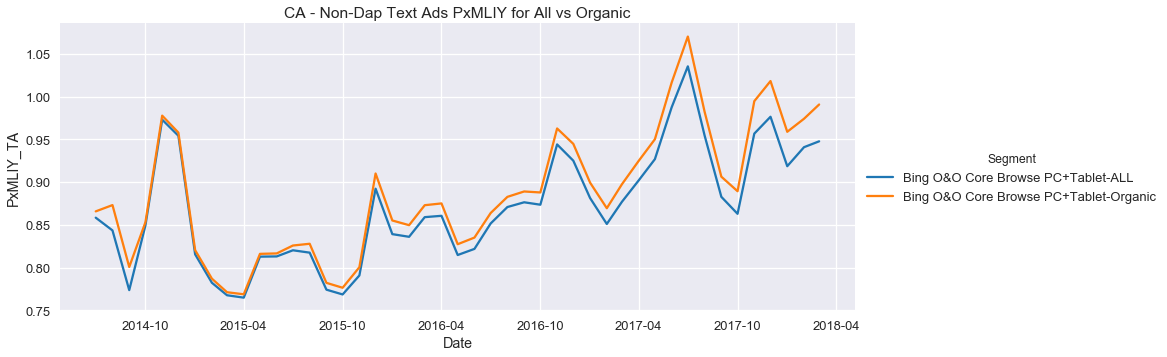

In [49]:
g = sns.FacetGrid(df_nonDap_monthly[(df_nonDap_monthly['Market_y']=='CA') & (df_nonDap_monthly['Date'] < '2018-04-01')], hue = 'Segment', size = 5, aspect = 2.5)
g.map(plt.plot, 'Date', 'PxMLIY_TA').add_legend()
g.ax.set(title = 'CA - Non-Dap Text Ads PxMLIY for All vs Organic')

[Text(0.5,1,'AU - Non-Dap Text Ads PxMLIY for All vs Organic')]

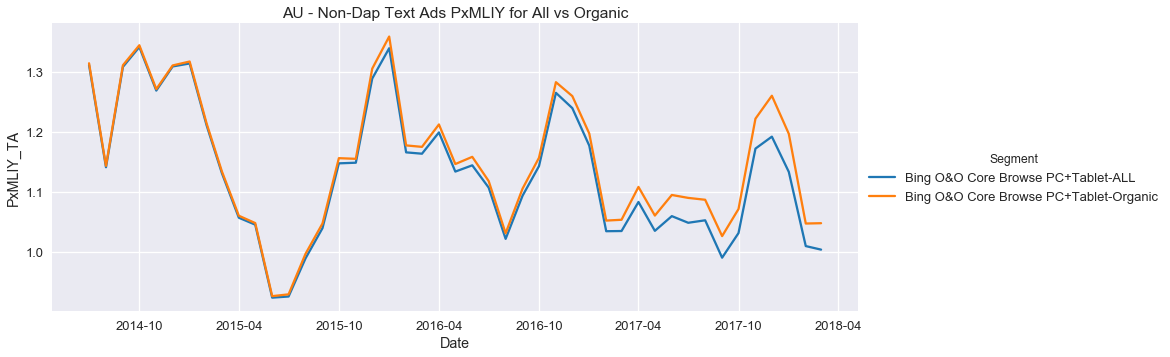

In [50]:
g = sns.FacetGrid(df_nonDap_monthly[(df_nonDap_monthly['Market_y']=='AU') & (df_nonDap_monthly['Date'] < '2018-04-01')], hue = 'Segment', size = 5, aspect = 2.5)
g.map(plt.plot, 'Date', 'PxMLIY_TA').add_legend()
g.ax.set(title = 'AU - Non-Dap Text Ads PxMLIY for All vs Organic')

In [51]:
df_nonDap_all_monthly.head()

,Date,Segment,Market,Market_Tag,CalendarPeriod,Impressions_SLAPI,WeightedTAImpressions,WeightedTextImpressions,WeightedDecoImpressions,PxMLIY_TA,PxMLIY_Text,PxMLIY_Deco,DecoRatio
0,2014-07-01,Bing O&O Core Browse PC+Tablet-ALL,de-DE-NonDap-ALL,2,2014-07,175930323,1.937061e+08,2.396481e+07,1.697412e+08,1.101038,0.136218,0.964821,0.876283
1,2014-07-01,Bing O&O Core Browse PC+Tablet-ALL,en-AU-NonDap-ALL,4,2014-07,107141725,1.405306e+08,1.754632e+07,1.229842e+08,1.311632,0.163767,1.147865,0.875142
2,2014-07-01,Bing O&O Core Browse PC+Tablet-ALL,en-CA-NonDap-ALL,5,2014-07,187341629,1.608365e+08,2.066296e+07,1.401736e+08,0.858520,0.110296,0.748224,0.871528
3,2014-07-01,Bing O&O Core Browse PC+Tablet-ALL,en-GB-NonDap-ALL,1,2014-07,375369276,3.343544e+08,5.773627e+07,2.766182e+08,0.890735,0.153812,0.736923,0.827320
4,2014-07-01,Bing O&O Core Browse PC+Tablet-ALL,fr-FR-NonDap-ALL,3,2014-07,237843612,2.411689e+08,3.062752e+07,2.105414e+08,1.013981,0.128772,0.885209,0.873004


In [52]:
df_nonDap_org_monthly.head()

,Date,Segment,Market,Market_Tag,CalendarPeriod,Impressions_SLAPI,WeightedTAImpressions,WeightedTextImpressions,WeightedDecoImpressions,PxMLIY_TA,PxMLIY_Text,PxMLIY_Deco,DecoRatio
5,2014-07-01,Bing O&O Core Browse PC+Tablet-Organic,de-DE-NonDap-ALL,2,2014-07,173680505,1.916956e+08,2.372018e+07,1.679754e+08,1.103726,0.136574,0.967152,0.876261
6,2014-07-01,Bing O&O Core Browse PC+Tablet-Organic,en-AU-NonDap-ALL,4,2014-07,106466305,1.399377e+08,1.747223e+07,1.224654e+08,1.314384,0.164110,1.150274,0.875143
7,2014-07-01,Bing O&O Core Browse PC+Tablet-Organic,en-CA-NonDap-ALL,5,2014-07,176778234,1.530723e+08,1.976908e+07,1.333032e+08,0.865900,0.111830,0.754070,0.870851
8,2014-07-01,Bing O&O Core Browse PC+Tablet-Organic,en-GB-NonDap-ALL,1,2014-07,371858487,3.314709e+08,5.729259e+07,2.741783e+08,0.891390,0.154071,0.737319,0.827157
9,2014-07-01,Bing O&O Core Browse PC+Tablet-Organic,fr-FR-NonDap-ALL,3,2014-07,232162952,2.370767e+08,3.011376e+07,2.069630e+08,1.021165,0.129710,0.891456,0.872979
